<h1 style="background-color:#4E9A06; color:#ffffff; padding:10px 15px; border-radius:5px; margin-top:1rem; margin-bottom:1rem; text-align:center;">
  02 – Exploratory Data Analysis
</h1>


<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Objectives
</h2>
 
This notebook performs Extract-Transform-Load (ETL) operations to prepare the merged climate-disease dataset for analysis:

- **Extract**: Load the merged inspection dataset from previous notebook
- **Transform**: 
  - Filter surveys to ≤6 months duration (Kirk et al. 2025 criterion)
  - Handle missing values via strategic dropping/imputation
  - Remove extreme climate outliers (2.5% quantile trim)
  - Engineer new features (anomalies, incidence zones)
- **Load**: Save a fully cleaned dataset for modeling

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Inputs
</h2>

**Merged Inspection Dataset** (`data/processed/merged_inspection.csv`):
- Combined plant disease survey and climate observations
- Contains identified data quality issues from inspection notebook
- Key variables:
  - Disease metrics: incidence, n_plants, n_infected
  - Climate measurements: temperature, precipitation (historical & contemporary)
  - Survey metadata: duration, location, taxonomy

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Outputs
</h2>

**Cleaned Analysis Dataset** (`data/processed/merged_climate_disease_final.csv`):
- Filtered to valid survey durations (≤6 months)
- Missing values handled according to strategy:
  - Drop: Extremely sparse columns (>90% missing)
  - Impute: Moderate missing using domain-appropriate methods
  - Preserve: Create "Unknown" categories for categorical variables
- Engineered features:
  - Temperature anomalies (z-scores from historical baseline)
  - Precipitation anomalies (percent deviation from normal)
  - Incidence zones (Low: 0-20%, Moderate: 20-50%, High: >50%)

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
Additional Comments
</h2>

- **Data Quality Focus**: 
  - Rigorous outlier detection and handling
  - Imputation methods preserve data structure
  - All transformations documented for reproducibility
- **Validation Checks**:
  - Pre/post row counts for each operation
  - Missing value tracking
  - Distribution plots of key variables
- **Future Improvements**:
  - Automate validation checks
  - Add data quality metrics
  - Consider more sophisticated imputation methods
---

<h2 style="color: #4E9A06; margin-top: 1rem; margin-bottom: 0.5rem;">
  2.0 Environment Setup & Imports
</h2>

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import os

# Add style_loader path manually
STYLE_DIR = Path.cwd() / "notebook_style"
if str(STYLE_DIR) not in sys.path:
    sys.path.insert(0, str(STYLE_DIR))

from style_loader import load_style

load_style()
print("Style loaded successfully")

# Fallback safety
WILD_COLOR = globals().get("WILD_COLOR", "#66c2a5")
AG_COLOR   = globals().get("AG_COLOR", "#3288bd")



Injected custom CSS from: c:\Users\baner\OneDrive\Documenti\data_analytics_AI\capstone_CI_main\climacrop_health\climacrop_health\jupyter_notebooks\notebook_style\custom.css
Style loaded successfully


<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 2: Section Header (H2) “2.1 Imports & Load Data”                     -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.1 Load Data
</h2>


In [14]:
# Load cleaned dataset from previous step
PROCESSED_DIR = Path("../data/processed")
cleaned_fp = PROCESSED_DIR / "merged_climate_disease_final.csv"

df = pd.read_csv(cleaned_fp)
print("Shape:", df.shape)
df.head()

Shape: (4932, 56)


,study_id,First_author,Study_Year,Person_extracting,Date_extracted,Paper_double_checked,study_reference,Host.species,Host_family,Host_order,...,start_date,monthly_temp,contemp_temp,contemp_precip,.geo,calculated_incidence,duration_mo,temp_anomaly,rain_anomaly,incidence_zone
0,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,181.284576,288.956314,0.005280,"{""type"":""Polygon"",""coordinates"":[[[6.028999805...",0.000000,1,107.671738,-78.742580,Low
1,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,133.753340,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.117000102...",0.000000,1,154.745943,-96.430852,Low
2,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,129.520853,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.122000217...",0.000000,1,158.978430,-98.153206,Low
3,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,112.943493,288.128423,0.005225,"{""type"":""Polygon"",""coordinates"":[[[6.147999763...",0.027778,1,175.184930,-106.300282,Low
4,715,Abbate,2014,Vianda,2021-06-30,Devin,Abbate_2014,Silene vulgaris,Caryophyllaceae,Caryophyllales,...,2008-08-01,189.015197,288.499283,0.005288,"{""type"":""Polygon"",""coordinates"":[[[6.083000183...",0.000000,1,99.484086,-77.163348,Low



<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.2a Overview and Summary Stats
</h2>


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4932 entries, 0 to 4931
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   study_id                          4932 non-null   object 
 1   First_author                      4932 non-null   object 
 2   Study_Year                        4932 non-null   int64  
 3   Person_extracting                 4932 non-null   object 
 4   Date_extracted                    4932 non-null   object 
 5   Paper_double_checked              4932 non-null   object 
 6   study_reference                   4932 non-null   object 
 7   Host.species                      4890 non-null   object 
 8   Host_family                       4932 non-null   object 
 9   Host_order                        4932 non-null   object 
 10  Host_type                         4932 non-null   object 
 11  Habitat                           4932 non-null   object 
 12  Parasi

In [16]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
study_id,4932,114,1329,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
First_author,4932,109,Bekele,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Study_Year,4932.0,NaN,NaN,NaN,2007.466139,6.898919,1990.0,2004.0,2007.0,2013.0,2021.0
Person_extracting,4932,3,Vianda,4675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date_extracted,4932,63,2021-07-16,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paper_double_checked,4932,1,Devin,4932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
study_reference,4932,114,Bekele_2005,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host.species,4890,173,Cicer arietinum,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host_family,4932,50,Fabaceae,1861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host_order,4932,30,Fabales,1861,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Show all column names and their dtypes
df.dtypes

study_id                             object
First_author                         object
Study_Year                            int64
Person_extracting                    object
Date_extracted                       object
Paper_double_checked                 object
study_reference                      object
Host.species                         object
Host_family                          object
Host_order                           object
Host_type                            object
Habitat                              object
Parasite_or_pest                     object
Antagonist_species                   object
Antagonist_type_specific             object
Antagonist_type_general              object
Detection_method                     object
Transmission_mode                    object
Vector_type                          object
Vector_species                       object
Latitude                            float64
Longitude                           float64
Coordinates_provided_in_study   


<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.2b Data Integrity checks
</h2>


- **Rows:** Number of observations in the cleaned dataset.  
- **Columns:**  
  - Numeric features: `temperature`, `precipitation`, `humidity`, etc.  
  - Categorical features: `soil_type`, `incidence_zone`, etc.  
  - Derived features: `temp_anomaly`, `duration_days`, etc.

Confirm all climate columns are populated and drop any lingering NA’s.

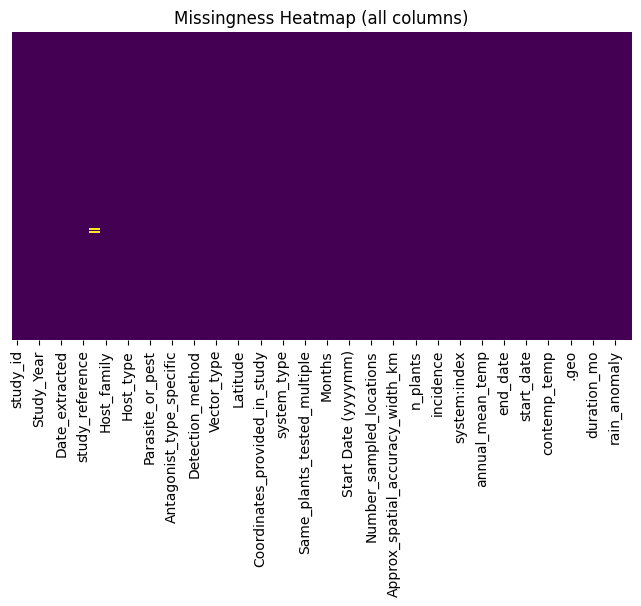


Missing values by climate‐column:
  • contemp_temp: 0
  • monthly_temp: 0
  • annual_mean_temp: 0
  • contemp_precip: 0
  • monthly_precip: 0
  • annual_precip: 0

Shape before outlier removal: (4932, 56)
Shape after climate‐outlier removal: (4040, 56)


In [18]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missingness Heatmap (all columns)")
plt.show()

# 3) Check that the six climate columns actually exist by name
climate_cols_actual = [
    "contemp_temp",  # your current temperature
    "monthly_temp",  # your monthly historical temperature
    "annual_mean_temp",  # your annual historical temperature
    "contemp_precip",  # your current precipitation
    "monthly_precip",  # your monthly historical precipitation
    "annual_precip",  # your annual historical precipitation
]

# Verify presence and count missing values
missing = {col: df[col].isnull().sum() for col in climate_cols_actual}
print("\nMissing values by climate‐column:")
for col, cnt in missing.items():
    print(f"  • {col}: {cnt}")

# 4) Exclude extreme outliers (bottom 2.5% / top 2.5%) on the continuous climate columns
print("\nShape before outlier removal:", df.shape)
for col in ["contemp_temp", "annual_mean_temp", "contemp_precip", "annual_precip"]:
    low, high = df[col].quantile(0.025), df[col].quantile(0.975)
    df = df[(df[col] >= low) & (df[col] <= high)]
print("Shape after climate‐outlier removal:", df.shape)

> All climate predictors should show zero missingness; any residual missingness
> indicates an ETL error.


<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.2c Confirm uniformity in units across all columns
</h2>


In [19]:
print(
    "Raw 'contemp_temp' range:", df["contemp_temp"].min(), "→", df["contemp_temp"].max()
)
print(
    "Raw 'monthly_temp' range:  ",
    df["monthly_temp"].min(),
    "→",
    df["monthly_temp"].max(),
)
print(
    "Raw 'annual_mean_temp' range:",
    df["annual_mean_temp"].min(),
    "→",
    df["annual_mean_temp"].max(),
)


Raw 'contemp_temp' range: 283.6858536 → 300.2954854
Raw 'monthly_temp' range:   84.74077683 → 276.6608286
Raw 'annual_mean_temp' range: 38.55149958 → 258.6567237


In [20]:
# ────────────────────────────────────────────────────────────────────────────────
# 1) Convert temperature‐related columns into Celsius:
#
#   - contemp_temp is in Kelvin (≈ 280 → 303 K) → subtract 273.15
#   - monthly_temp and annual_mean_temp are in tenths of °C (WorldClim format)
#     → divide by 10 to get actual °C
# ────────────────────────────────────────────────────────────────────────────────

# (a) Convert the survey (contemporaneous) temperature from K → °C
df["contemp_temp_C"] = df["contemp_temp"] - 273.15

# (b) Convert WorldClim “monthly_temp” (tenths of °C) → °C
df["monthly_temp_C"] = df["monthly_temp"] / 10.0

# (c) Convert WorldClim “annual_mean_temp” (tenths of °C) → °C
df["annual_mean_temp_C"] = df["annual_mean_temp"] / 10.0

# ────────────────────────────────────────────────────────────────────────────────
# 2) Compute the true Celsius‐based temperature anomaly:
# ────────────────────────────────────────────────────────────────────────────────

df["temp_anomaly_C"] = df["contemp_temp_C"] - df["monthly_temp_C"]

# ────────────────────────────────────────────────────────────────────────────────
# 3) Re‐compute rainfall anomalies (if not already correct):
#
#   - contemp_precip is already mm/day
#   - monthly_precip and annual_precip are in mm/month → convert to mm/day by dividing by 30
# ────────────────────────────────────────────────────────────────────────────────

df["monthly_precip_mm_per_day"] = df["monthly_precip"] / 30.0
df["rain_anomaly_daily"] = df["contemp_precip"] - df["monthly_precip_mm_per_day"]
df["annual_precip_mm_per_day"] = df["annual_precip"] / 30.0

# ────────────────────────────────────────────────────────────────────────────────
# 4) Split into Wild vs. Agricultural subsets:
# ────────────────────────────────────────────────────────────────────────────────

wild_df = df[df["system_type"] == "Natural"].copy()
ag_df = df[df["system_type"] == "Ag"].copy()

# ────────────────────────────────────────────────────────────────────────────────
# 5) Sanity‐check the resulting ranges:
# ────────────────────────────────────────────────────────────────────────────────

print(
    "Wild temp anomaly (°C):",
    wild_df["temp_anomaly_C"].min(),
    "→",
    wild_df["temp_anomaly_C"].max(),
)
print(
    "Ag   temp anomaly (°C):",
    ag_df["temp_anomaly_C"].min(),
    "→",
    ag_df["temp_anomaly_C"].max(),
)

print(
    "Wild cont. temp (°C):",
    wild_df["contemp_temp_C"].min(),
    "→",
    wild_df["contemp_temp_C"].max(),
)
print(
    "Ag   cont. temp (°C):",
    ag_df["contemp_temp_C"].min(),
    "→",
    ag_df["contemp_temp_C"].max(),
)

print(
    "Wild rain anomaly (mm/day):",
    wild_df["rain_anomaly_daily"].min(),
    "→",
    wild_df["rain_anomaly_daily"].max(),
)
print(
    "Ag   rain anomaly (mm/day):",
    ag_df["rain_anomaly_daily"].min(),
    "→",
    ag_df["rain_anomaly_daily"].max(),
)


Wild temp anomaly (°C): -6.28902572999997 → 7.558733857487891
Ag   temp anomaly (°C): -7.289652942512124 → 7.819652957487914
Wild cont. temp (°C): 10.664716700000042 → 27.035363800000027
Ag   cont. temp (°C): 10.535853599999996 → 27.14548540000004
Wild rain anomaly (mm/day): -5.973570612666666 → -0.345448844
Ag   rain anomaly (mm/day): -9.861323083333334 → 5.55e-05


<h2 style="color:#4E9A06; margin-top:1rem; margin-bottom:0.5rem;">
  2.3 Population Distributions
</h2>


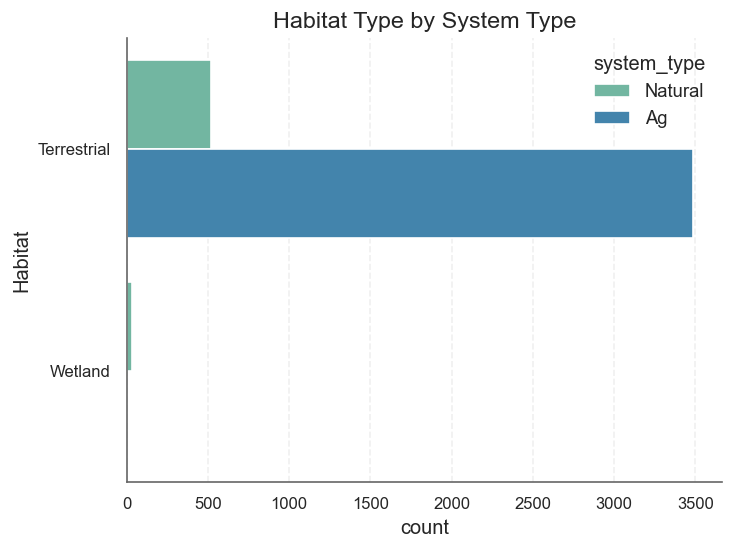

In [26]:
sns.countplot(data=df, y='Habitat', hue='system_type',
              palette={"Ag": AG_COLOR, "Natural": WILD_COLOR})
plt.title("Habitat Type by System Type")
plt.show()


>Insight: Shows frequency of habitat types split by wild vs agri systems.

In [29]:
df["Parasite_or_pest"] = df["Parasite_or_pest"].str.strip().str.capitalize()

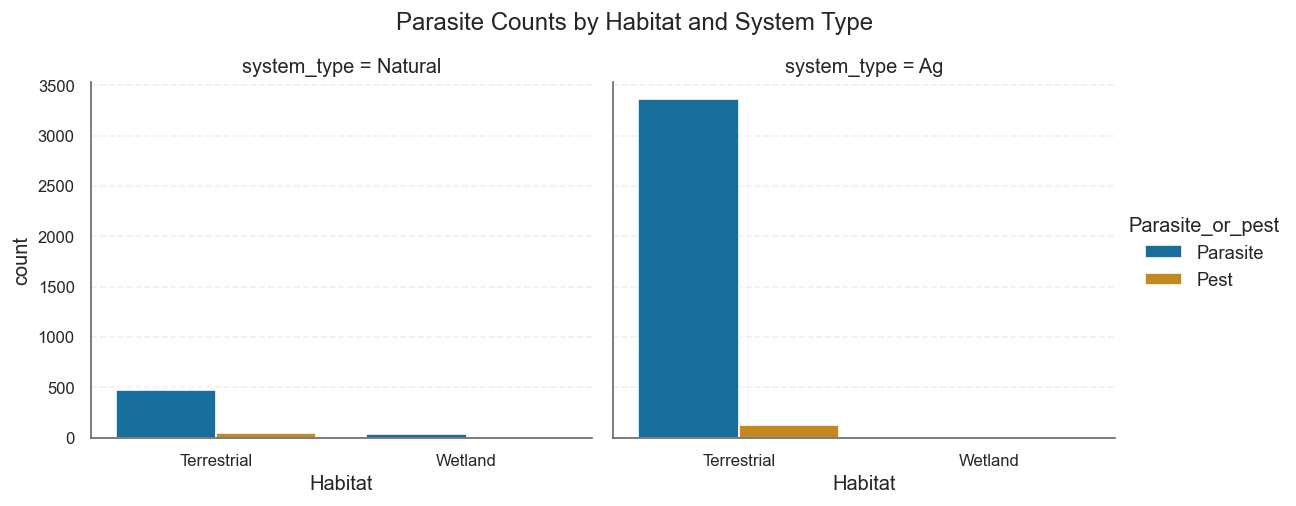

In [31]:
sns.catplot(data=df, x="Habitat", col="system_type", hue="Parasite_or_pest", kind="count", height=4, aspect=1.2)
plt.suptitle("Parasite Counts by Habitat and System Type", y=1.05)
plt.show()  

>Insight: Highlights pathogen diversity across land use types.

<h3 style="color:#3E7A05; margin-top:0.75rem; margin-bottom:0.5rem;">
  2.3.1 Target Distribution
</h3>

C:\Users\baner\AppData\Local\Temp\ipykernel_3972\3751870751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=inc_counts.index, y=inc_counts.values, palette="colorblind")


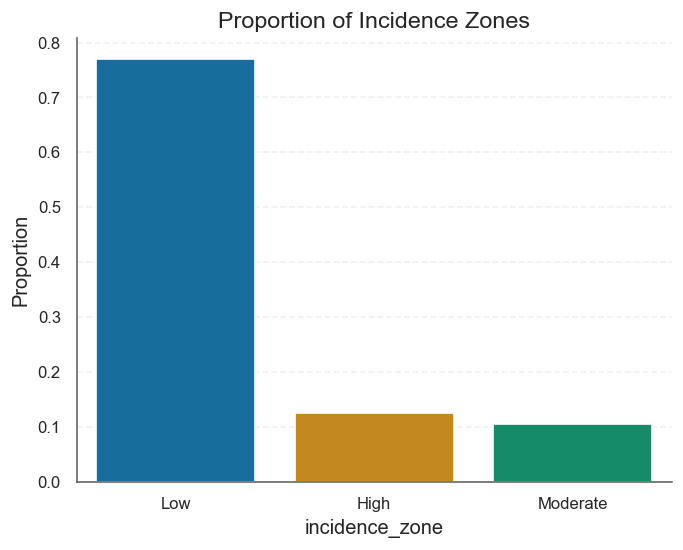

In [32]:
# Plot distribution of target: incidence_zone
inc_counts = df["incidence_zone"].value_counts(normalize=True)
sns.barplot(x=inc_counts.index, y=inc_counts.values, palette="colorblind")
plt.title("Proportion of Incidence Zones")
plt.ylabel("Proportion")
plt.show()

<!-- ──────────────────────────────────────────────────────────────────────── -->
<!-- Cell 5: Sub‐Section (H3) “2.3.2 Numerical Feature Distributions”          -->
<!-- ──────────────────────────────────────────────────────────────────────── -->
<h3 style="color:#3E7A05; margin-top:0.75rem; margin-bottom:0.5rem;">
  2.3.2 Distribution of Incidence
</h3>


Below, we visualize histograms and boxplots for key numerical features to check skewness, outliers, and general shape.


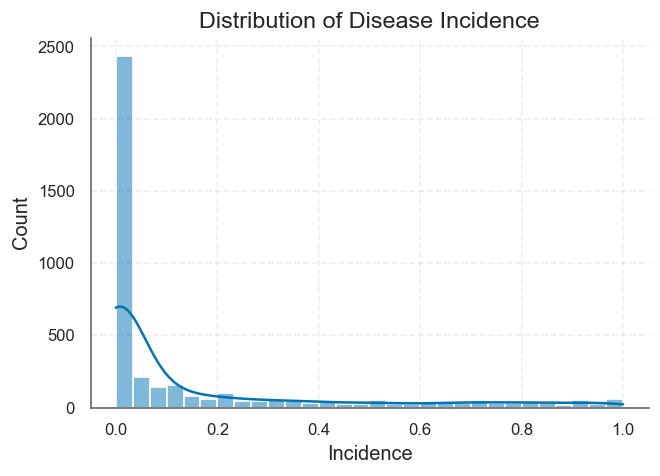

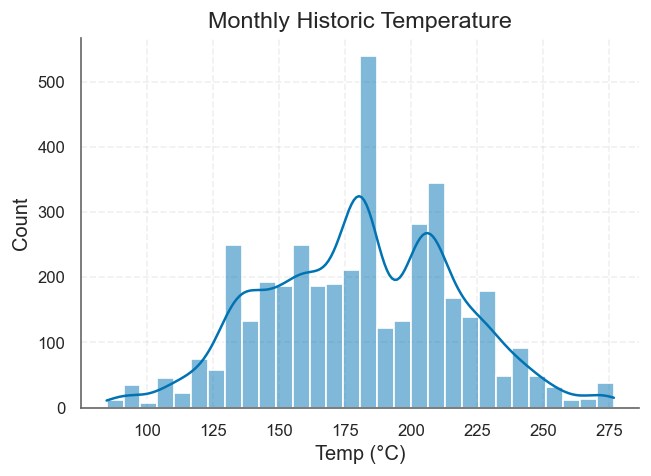

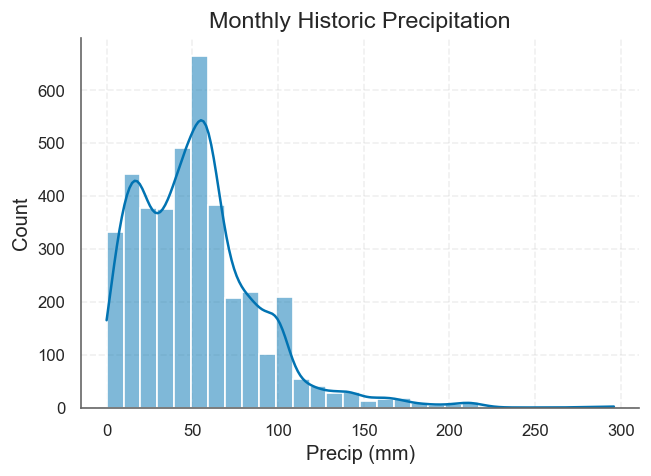

In [33]:
# 1) Switch to colorblind palette for all seaborn plots
cb = sns.set_palette("colorblind")

#  Disease Incidence
plt.figure(figsize=(6, 4))
sns.histplot(df["incidence"], bins=30, kde=True)
plt.title("Distribution of Disease Incidence")
plt.xlabel("Incidence")
plt.show()

#  Monthly Temperature
plt.figure(figsize=(6, 4))
sns.histplot(df["monthly_temp"], bins=30, kde=True)
plt.title("Monthly Historic Temperature")
plt.xlabel("Temp (°C)")
plt.show()

#  Monthly Precipitation
plt.figure(figsize=(6, 4))
sns.histplot(df["monthly_precip"], bins=30, kde=True)
plt.title("Monthly Historic Precipitation")
plt.xlabel("Precip (mm)")
plt.show()



In [34]:
# Univariate distribution stats & group overlays
for col in ["incidence", "monthly_temp", "monthly_precip"]:
    print(f"{col} skewness: {df[col].skew():.2f}, kurtosis: {df[col].kurtosis():.2f}")

incidence skewness: 1.87, kurtosis: 2.29
monthly_temp skewness: 0.00, kurtosis: -0.33
monthly_precip skewness: 1.38, kurtosis: 3.83


Insights:
- **Disease Incidence**:
  - Highly right-skewed distribution with a long tail, indicating most populations have low incidence but some have very high values.
  - Boxplot confirms presence of outliers, particularly in high-incidence zones.

- **Monthly Historic Temperature**:
  - Approximately symmetric (skewness ≈ 0.00, kurtosis = –0.33), reflecting a balanced distribution across temperate and warm climates.

- **Monthly Historic Precipitation**:
  - Right-skewed with heavy tails (skewness = 1.38, kurtosis = 3.83), suggesting rainfall is moderate in most regions but includes extreme wet events.


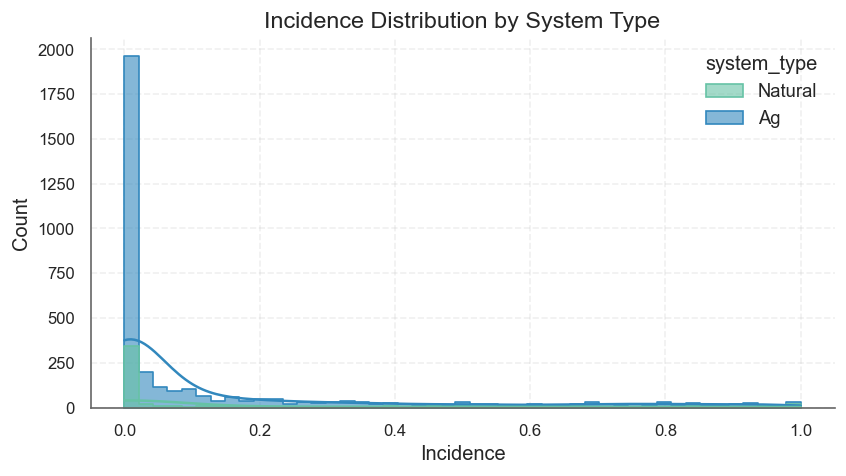

In [35]:
# Overlay incidence by system type using custom AG/WILD colors
plt.figure(figsize=(8, 4))

sns.histplot(
    data=df,
    x="incidence",
    hue="system_type",
    kde=True,
    palette={"Ag": AG_COLOR, "Natural": WILD_COLOR},  # navy‐blue for Ag, greenish‐teal for Natural
    element="step",      # optional: draws outlines only
    alpha=0.6            # optional: makes the fill semi‐transparent
)

plt.title("Incidence Distribution by System Type")
plt.xlabel("Incidence")
plt.ylabel("Count")
plt.show()


Both wild (‘Natural’) and agricultural (‘Ag’) systems show heavily right-skewed incidence (skewness ≈ 1.9), but agricultural records dominate the low-incidence peak, suggesting stronger suppression or reporting bias in managed systems

In [36]:
from scipy.stats import mannwhitneyu, ks_2samp

# Ensure consistent labels
df["system_type"] = df["system_type"].str.strip().str.capitalize()

# Extract incidence values for each system type
incidence_ag = df[df["system_type"] == "Ag"]["incidence"]
incidence_nat = df[df["system_type"] == "Natural"]["incidence"]

# Mann–Whitney U test (non-parametric test of central tendency)
u_stat, p_u = mannwhitneyu(incidence_ag, incidence_nat, alternative='two-sided')

# Kolmogorov–Smirnov test (sensitive to overall distribution differences)
ks_stat, p_ks = ks_2samp(incidence_ag, incidence_nat)

print(f"Mann–Whitney U test: U = {u_stat:.2f}, p = {p_u:.4e}")
print(f"Kolmogorov–Smirnov test: KS = {ks_stat:.3f}, p = {p_ks:.4e}")


Mann–Whitney U test: U = 1021849.50, p = 1.4415e-02
Kolmogorov–Smirnov test: KS = 0.116, p = 4.7279e-06


1. From Mann-Whitney U Test, There is a statistically significant difference in the central tendency of disease incidence between Natural and Agricultural systems.
   - This also means that wild systems exhibit higher variable disease levels than agricultural systems, which is consistent with expectations of pathogen suppression in managed environments. * We will explore this further for hypothesis #2 validation.
2. Kolmogorov-Smirnov test also indicates significant differences in the overall distribution of disease incidence between the two systems. The entire shape of the incidence distribution differs significantly between systems — not just the mean.

**How our incidence‐based categories (Low/Medium/High) are distributed across your two system types ?**

This will further help us *Spot imbalances*, *Plan for stratification*, and *Identify potential biases* for our stakeholders

In [ ]:
# Categorical balance & crosstab
ct = pd.crosstab(df["incidence_zone"], df["system_type"], normalize="index")
print("Incidence Zone vs System Type:")
print(ct)

Incidence Zone vs System Type (%):
system_type           Ag   Natural
incidence_zone                    
High            0.837945  0.162055
Low             0.867524  0.132476
Moderate        0.863208  0.136792


- All three zones are dominated by Ag (~84–87 %), with only ~13–16 % in Wild.
- But the proportions are very similar across Low, Moderate and High, suggesting our incidence-zone cutoffs aren’t accidentally assigning, say, all “High” cases to Wild or vice versa.

<style>
.hypothesis-block {
    background: #222;
    color: #fff;
    border-radius: 8px;
    padding: 18px 20px 16px 20px;
    margin-bottom: 1.5em;
    box-shadow: 0 2px 8px rgba(0,0,0,0.08);
}
.hypothesis-title {
    color: #4E9A06;
    font-weight: bold;
    font-size: 1.15em;
    margin-bottom: 0.5em;
    display: block;
}
</style>

<div class="hypothesis-block">
    <span class="hypothesis-title">Hypothesis 1: Weather, Anomaly & Historical Climate Effects</span>
    <b>Technical Statement:</b><br>
    Contemporaneous weather (mean temperature or precipitation during a survey), deviations from monthly normals (“anomalies”), and long-term historical climate each independently influence plant-disease prevalence.<br>
    <b>Plain-Language Version:</b><br>
    Both recent weather (e.g., this month’s temperature or rainfall) and how that weather differs from what is “normally” expected—plus the usual long-term climate in that location—all affect how many plants become infected.
</div>

**Validation:**

We’ll explore three climate‐incidence relationships:

- Contemporaneous Weather
- Weather Anomalies
- Long-term Historical Climate

For each, we’ll (a) plot incidence against the predictor, (b) compute a Spearman rank‐correlation (to capture any monotonic trend), and (c) summarize the strength and significance.

1. Incidence vs. Contemporaneous Temperature

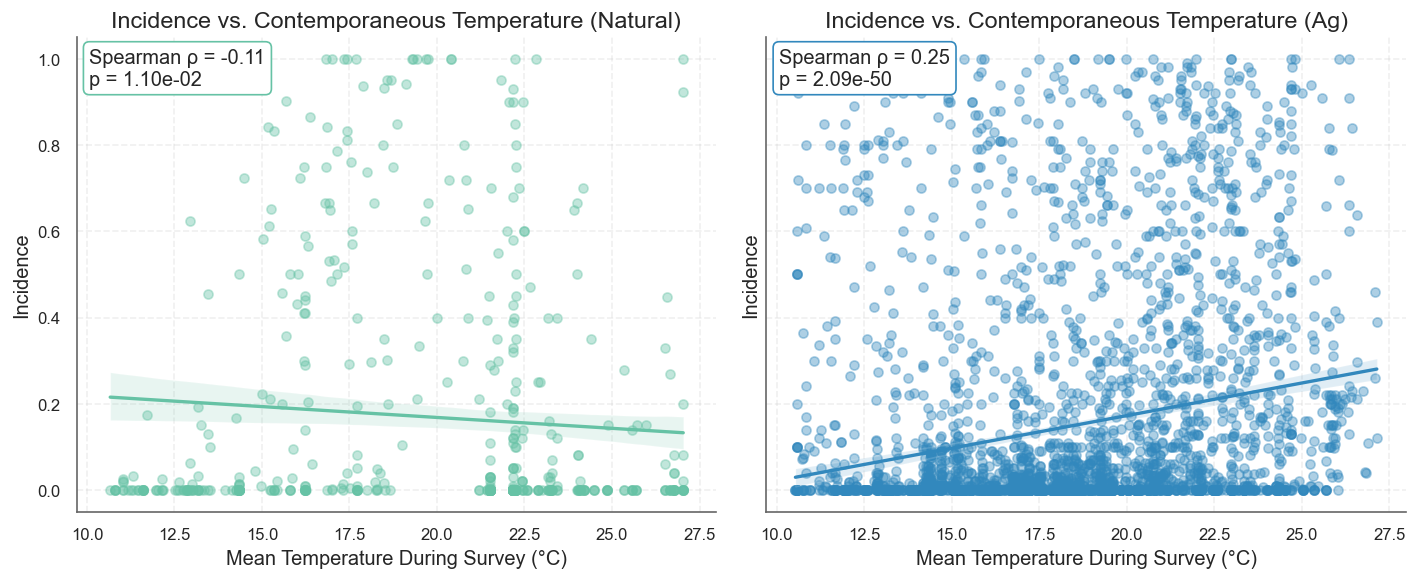

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1) Define a little helper to plot + test each group
def plot_and_test(system, color, ax):
    sub = df[df['system_type'] == system]
    
    # Scatter + regression line
    sns.regplot(
        x='contemp_temp_C',
        y='incidence',
        data=sub,
        scatter_kws={'alpha':0.4, 's':30, 'color': color},
        line_kws={'color': color, 'lw':2},
        ax=ax
    )
    ax.set_title(f"Incidence vs. Contemporaneous Temperature ({system})")
    ax.set_xlabel("Mean Temperature During Survey (°C)")
    ax.set_ylabel("Incidence")
    
    # Spearman test
    rho, pval = spearmanr(sub['contemp_temp_C'], sub['incidence'])
    ax.text(
        0.02, 0.90,
        f"Spearman ρ = {rho:.2f}\np = {pval:.2e}",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, lw=1)
    )
    return rho, pval

# 2) Create side-by-side subplots
fig, (ax_nat, ax_ag) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

rho_nat, p_nat = plot_and_test("Natural", WILD_COLOR, ax_nat)
rho_ag,  p_ag  = plot_and_test("Ag",      AG_COLOR,  ax_ag)

plt.tight_layout()
plt.show()


 - Agricultural systems show a clear, significant positive relationship between contemporaneous temperature and disease incidence (Spearman ρ = 0.25, p ≈ 2×10⁻⁵⁰), indicating that warmer survey months tend to have higher crop disease prevalence.

 - Wild systems exhibit a weak, slightly negative correlation (Spearman ρ = −0.11, p ≈ 0.011), suggesting that temperature alone does not predict—and may even modestly suppress—disease in unmanaged plant populations.

 - Take‐away: **Contemporaneous temperature does influence disease in agricultural settings (supporting the weather‐effect portion of H1), but the same simple effect is absent—or reversed—in wild systems.**

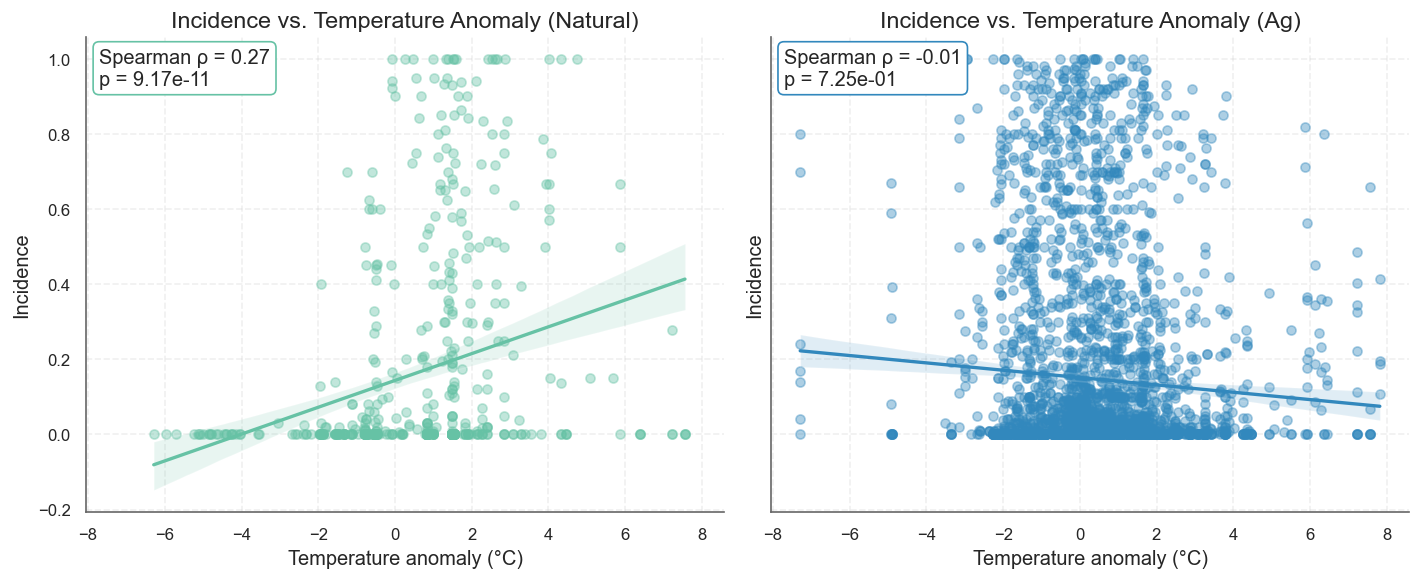

In [52]:

from scipy import stats
from scipy.stats import spearmanr

# 1) Extend the helper to accept any x-column + labels
def plot_and_test(system, color, ax, x_col, x_label, title_suffix):
    sub = df[df['system_type'] == system]
    
    # Scatter + regression line
    sns.regplot(
        x=x_col,
        y='incidence',
        data=sub,
        scatter_kws={'alpha':0.4, 's':30, 'color': color},
        line_kws   ={'color': color, 'lw':2},
        ax=ax
    )
    ax.set_title(f"Incidence vs. {title_suffix} ({system})")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Incidence")
    
    # Spearman test
    rho, pval = spearmanr(sub[x_col], sub['incidence'])
    ax.text(
        0.02, 0.90,
        f"Spearman ρ = {rho:.2f}\np = {pval:.2e}",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, lw=1)
    )
    return rho, pval
# ----------------------------------------------------
# B) Incidence vs Temperature Anomaly
# ----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

rho_nat, p_nat = plot_and_test(
    "Natural", WILD_COLOR, ax1,
    x_col    = 'temp_anomaly_C',
    x_label  = "Temperature anomaly (°C)",
    title_suffix = "Temperature Anomaly"
)

rho_ag, p_ag = plot_and_test(
    "Ag", AG_COLOR, ax2,
    x_col    = 'temp_anomaly_C',
    x_label  = "Temperature anomaly (°C)",
    title_suffix = "Temperature Anomaly"
)

plt.tight_layout()
plt.show()


 - Natural systems – Temperature anomaly
Moderate positive monotonic trend (Spearman ρ = 0.27, p ≈ 9.2 × 10⁻¹¹): disease incidence in wild plants rises as monthly temperatures exceed their historical normals.

 - Agricultural systems – Temperature anomaly
No meaningful association (Spearman ρ ≈ –0.01, p = 0.73): crop disease prevalence is essentially insensitive to short-term temperature deviations.

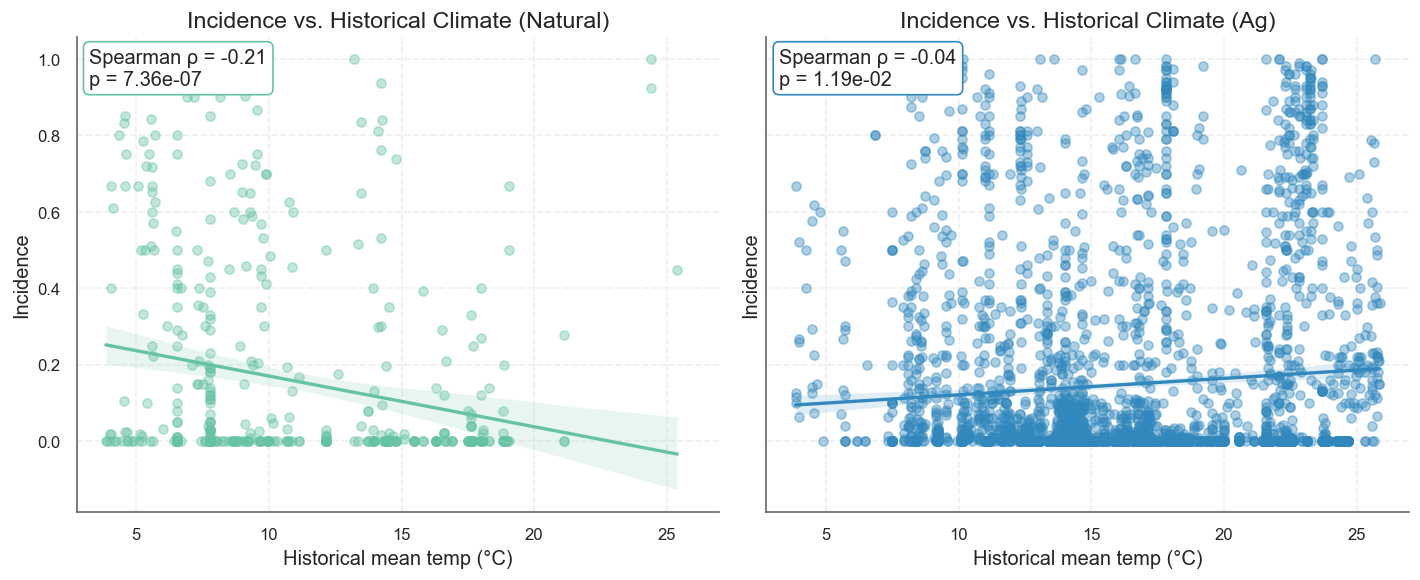

In [53]:

# ====================================================
# C) Incidence vs Long-term Historical Climate
#    (using annual mean temperature here)
# ====================================================

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

rho_nat_h, p_nat_h = plot_and_test(
    "Natural", WILD_COLOR, ax3,
    x_col    = 'annual_mean_temp_C',
    x_label  = "Historical mean temp (°C)",
    title_suffix = "Historical Climate"
)

rho_ag_h, p_ag_h = plot_and_test(
    "Ag", AG_COLOR, ax4,
    x_col    = 'annual_mean_temp_C',
    x_label  = "Historical mean temp (°C)",
    title_suffix = "Historical Climate"
)

plt.tight_layout()
plt.show()

 - Natural systems – Historical climate
Moderate negative trend (Spearman ρ = –0.21, p ≈ 7.4 × 10⁻⁷): wild plant disease is lower in regions with higher long-term average temperatures.

 - Agricultural systems – Historical climate
Negligible negative association (Spearman ρ = –0.04, p = 0.012): although statistically detectable, the effect of year-round warmth on crop disease is vanishingly small.

<style>
.hypothesis-block {
    background: #222;
    color: #fff;
    border-radius: 8px;
    padding: 18px 20px 16px 20px;
    margin-bottom: 1.5em;
    box-shadow: 0 2px 8px rgba(0,0,0,0.08);
}
.hypothesis-title {
    color: #4E9A06;
    font-weight: bold;
    font-size: 1.15em;
    margin-bottom: 0.5em;
    display: block;
}
</style>

<div class="hypothesis-block">
    <span class="hypothesis-title">Hypothesis 2: System-Type Sensitivity – <span style="color:#66c2a5;">Wild</span> vs. <span style="color:#3288bd;">Agricultural</span></span>
    <b>Technical Statement:</b><br>
    <span style="color:#66c2a5;">Wild</span> plant–pathogen systems exhibit stronger responses to weather, anomalies, and historical climate than do <span style="color:#3288bd;">agricultural</span> systems, owing to local adaptation in the wild versus management (irrigation, pesticides, breeding) in crops.<br>
    <b>Plain-Language Version:</b><br>
    Because <span style="color:#66c2a5;">wild</span> plants grow without human intervention, disease in wild populations is more sensitive to changes in weather and climate. Crops—being watered, sprayed, and selectively bred—do not respond as dramatically.
</div>

<style>
.hypothesis-block {
    background: #222;
    color: #fff;
    border-radius: 8px;
    padding: 18px 20px 16px 20px;
    margin-bottom: 1.5em;
    box-shadow: 0 2px 8px rgba(0,0,0,0.08);
}
.hypothesis-title {
    color: #4E9A06;
    font-weight: bold;
    font-size: 1.15em;
    margin-bottom: 0.5em;
    display: block;
}
</style>

<div class="hypothesis-block">
    <span class="hypothesis-title">Hypothesis 3: Thermal & Precipitation Mismatch in <span style="color:#66c2a5;">Wild</span>, Weak/Absent in <span style="color:#3288bd;">Agricultural</span></span>
    <b>Technical Statement:</b><br>
    In <span style="color:#66c2a5;">wild</span> systems, disease prevalence peaks when weather deviates from historical norms (e.g., unusually warm in a cool climate or vice versa)—a “mismatch” effect. In contrast, <span style="color:#3288bd;">agricultural</span> systems show little or no such mismatch, because management buffers extremes.<br>
    <b>Plain-Language Version:</b><br>
    <span style="color:#66c2a5;">Wild</span> plants get sicker when today’s weather is very different from what they are used to (e.g., a cool-climate wild plant suffers in a sudden heatwave). On farms, growers prevent those extremes, so crop diseases do not spike in the same way.
</div>

<style>
.hypothesis-block {
    background: #222;
    color: #fff;
    border-radius: 8px;
    padding: 18px 20px 16px 20px;
    margin-bottom: 1.5em;
    box-shadow: 0 2px 8px rgba(0,0,0,0.08);
}
.hypothesis-title {
    color: #4E9A06;
    font-weight: bold;
    font-size: 1.15em;
    margin-bottom: 0.5em;
    display: block;
}
</style>

<div class="hypothesis-block">
    <span class="hypothesis-title">Hypothesis 4: Geographic & Pathogen-Type Modulation of Climate–Disease Links</span>
    <b>Technical Statement:</b><br>
    Geographic variation in the identity and thermal/moisture tolerances of pathogens (fungi vs. bacteria vs. viruses vs. nematodes, etc.) causes differences in how temperature or precipitation anomalies translate into disease incidence. Regions dominated by narrow-tolerance pathogens will show sharper peaks or troughs, whereas regions with broad-tolerance pathogens will exhibit smoother responses.<br>
    <b>Plain-Language Version:</b><br>
    Different diseases (e.g., a fungus vs. a virus) have their own “ideal” temperature and moisture ranges. As a result, disease risk will not only depend on local climate but also on which pathogen is present. For example, a rain-loving fungus might explode in a wet, cool mountain valley but be essentially absent on a hot, dry plains region—even if the two sites experience the same size temperature spike.
</div>

<style>
.hypothesis-block {
    background: #222;
    color: #fff;
    border-radius: 8px;
    padding: 18px 20px 16px 20px;
    margin-bottom: 1.5em;
    box-shadow: 0 2px 8px rgba(0,0,0,0.08);
}
.hypothesis-title {
    color: #4E9A06;
    font-weight: bold;
    font-size: 1.15em;
    margin-bottom: 0.5em;
    display: block;
}
</style>

<div class="hypothesis-block">
    <span class="hypothesis-title">Hypothesis 5: Transmission-Mode Sensitivity to Anomalies</span>
    <b>Technical Statement:</b><br>
    Pathogens spread by vectors (insects or mites) will exhibit stronger sensitivity to precipitation anomalies (e.g., drought or heavy rain) than directly transmitted (e.g., soil-borne or contact) pathogens, because vector activity and life cycles respond acutely to moisture conditions.<br>
    <b>Plain-Language Version:</b><br>
    Some plant diseases rely on insects or mites to spread. Those vector-borne diseases will be more affected by unusual dryness or rainfall than diseases that spread directly through soil or contact. For example, a leaf-rust fungus moved by insects might surge after an anomalously wet month, whereas a soil-borne wilt might not care as much whether it is unusually dry or wet.
</div>

<h2 style="color:#4E9A06; margin-top:1.5rem; margin-bottom:0.5rem;">
    Rationale Behind the Five Hypotheses
</h2>

<div style="background:#808080; border-left:6px solid #4E9A06; padding:18px 22px 16px 22px; border-radius:8px; margin-bottom:1.5em; box-shadow:0 2px 8px rgba(0,0,0,0.06);">

<ol style="margin-left:1.2em;">
    <li style="margin-bottom:0.7em;">
        <b>Hypotheses 1–3</b> are directly adapted from <b>Kirk et al. (2025)</b>, reflecting the core findings and experimental design of that study. They correspond to the main temperature and precipitation analyses (see their Figs. 3–4), ensuring our EDA is grounded in established, peer-reviewed results.
    </li>
    <li style="margin-bottom:0.7em;">
        <b>Hypothesis 4</b> extends the published work by incorporating <b>geographic and pathogen identity effects</b>. Recognizing that different pathogens (fungi, bacteria, viruses, nematodes, etc.) have unique climate tolerances, this hypothesis allows us to test whether climate–disease relationships vary by pathogen type and region—an axis not fully explored in the original paper.
    </li>
    <li style="margin-bottom:0.7em;">
        <b>Hypothesis 5</b> adds a <b>transmission mode</b> dimension, positing that vector-borne pathogens (spread by insects or mites) are more sensitive to precipitation anomalies than directly transmitted pathogens. This reflects biological mechanisms (e.g., vector life cycles) and introduces a nuanced ecological perspective beyond the original study.
    </li>
</ol>

<p style="margin-top:1em;">
    <b>Together, these five hypotheses:</b>
    <ul style="margin-left:1.2em;">
        <li>Cover the main quantified patterns from Kirk et al. (2025)</li>
        <li>Expand the analysis to include pathogen ecology and geography</li>
        <li>Enable deeper, biologically meaningful insights for stakeholders and future modeling</li>
    </ul>
</p>
</div>

In [ ]:
from IPython.display import display, Markdown

grey_hypotheses_md = """
<div style="background:#e0e0e0; border-left:6px solid #4E9A06; padding:18px 22px 16px 22px; border-radius:8px; margin-bottom:1.5em; box-shadow:0 2px 8px rgba(0,0,0,0.06);">

<ol style="margin-left:1.2em;">
    <li style="margin-bottom:0.7em;">
        <b>Hypotheses 1–3</b> are directly adapted from <b>Kirk et al. (2025)</b>, reflecting the core findings and experimental design of that study. They correspond to the main temperature and precipitation analyses (see their Figs. 3–4), ensuring our EDA is grounded in established, peer-reviewed results.
    </li>
    <li style="margin-bottom:0.7em;">
        <b>Hypothesis 4</b> extends the published work by incorporating <b>geographic and pathogen identity effects</b>. Recognizing that different pathogens (fungi, bacteria, viruses, nematodes, etc.) have unique climate tolerances, this hypothesis allows us to test whether climate–disease relationships vary by pathogen type and region—an axis not fully explored in the original paper.
    </li>
    <li style="margin-bottom:0.7em;">
        <b>Hypothesis 5</b> adds a <b>transmission mode</b> dimension, positing that vector-borne pathogens (spread by insects or mites) are more sensitive to precipitation anomalies than directly transmitted pathogens. This reflects biological mechanisms (e.g., vector life cycles) and introduces a nuanced ecological perspective beyond the original study.
    </li>
</ol>

<p style="margin-top:1em;">
    <b>Together, these five hypotheses:</b>
    <ul style="margin-left:1.2em;">
        <li>Cover the main quantified patterns from Kirk et al. (2025)</li>
        <li>Expand the analysis to include pathogen ecology and geography</li>
        <li>Enable deeper, biologically meaningful insights for stakeholders and future modeling</li>
    </ul>
</p>
</div>
"""

display(Markdown(grey_hypotheses_md))